# Training Preview in Brax v2

Welcome to a preview of [Brax v2](https://github.com/google/brax/tree/main/brax/v2), a massive update full of new capabilities! Our new `generalized` backend is designed for fast and realistic simulation with the following features: 

* physics steps in generalized coordinates, avoiding joint violations
* forward and inverse smooth dynamics of articulated systems
* constraint solving for joint limits and contacts with pyramidal friction cone
* full inertia matrix calculation for dynamics and constraint solving

To demonstrate the new API, we'll be training an Ant using our new `generalized` physics backend. Let's try it out!

In [ ]:
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

import functools
import jax

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

import flax
from brax.v2 import envs
from brax.io import model
from brax.v2.io import json
from brax.v2.io import html
from brax.v2.training.agents.ppo import train as ppo

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

First let's load and visualize an Ant environment using the new `generalized` backend.

Notice that when calling `envs.get_environment`, we can now specify the physics `backend` to use! The `spring` backend is available in v2 as well, and `positional` PBD will soon be ported over to the v2 API.

In [ ]:
#@title Load Ant { run: "auto" }

env_name = "ant"

env = envs.get_environment(env_name=env_name,
                           backend='generalized')
state = env.reset(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(env.sys, [state.pipeline_state.x]))

The System parameters in `env.sys`, everything you need to run a Brax system, are now fully jax traceable in a flax dataclass! We could eventually randomize over System parameters to better handle sim2sim and sim2real transfer.

In [ ]:
flax.struct.dataclasses.is_dataclass(env.sys)

True

# Training

Let's train the Ant policy using the `generalized` backend with PPO.

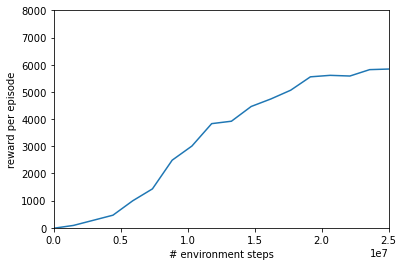

time to jit: 0:00:33.268636
time to train: 0:02:36.432970


In [ ]:
#@title Training the Ant

# We determined some reasonable hyperparameters offline and share them here.
train_fn = functools.partial(ppo.train, num_timesteps=25000000, num_evals=20,
                             reward_scaling=10, episode_length=1000,
                             normalize_observations=True, action_repeat=1,
                             unroll_length=5, num_minibatches=32,
                             num_updates_per_batch=4, discounting=0.97,
                             learning_rate=3e-4, entropy_cost=1e-2,
                             num_envs=2048, batch_size=1024)

max_y = 8000
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

# Save and Visualize the Policy

We can save and load the policy to visualize, just like we did in v1.

In [ ]:
model.save_params('/tmp/params-v2-generalized', params)
params = model.load_params('/tmp/params-v2-generalized')
inference_fn = make_inference_fn(params)

In [ ]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

xs = [state.pipeline_state.x for state in rollout]
HTML(html.render(env.sys.replace(dt=env.dt), xs))

🙌 See you soon!